In [85]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('train.csv',dtype={"Age": np.float64})
test = pd.read_csv('test.csv',dtype={"Age": np.float64})
PassengerId=test['PassengerId']
all_data = pd.concat([train, test], ignore_index = True)

In [86]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


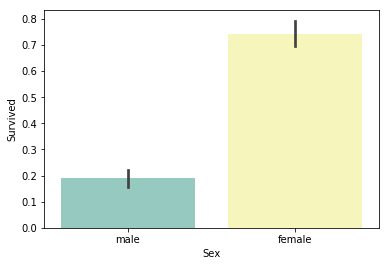

In [87]:
sns.barplot(x="Sex", y="Survived", data=train, palette='Set3')

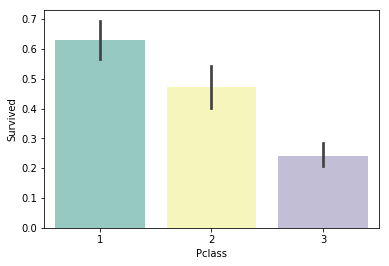

In [88]:
sns.barplot(x="Pclass", y="Survived", data=train, palette='Set3')

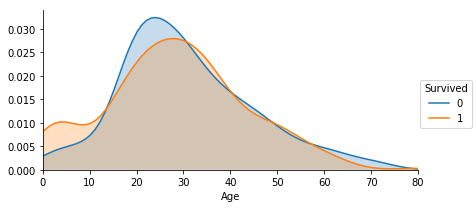

In [89]:
facet = sns.FacetGrid(train, hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

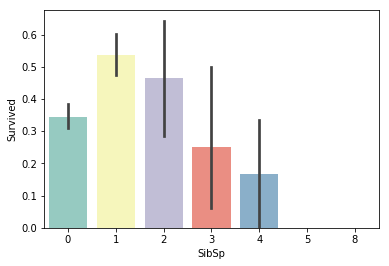

In [90]:
sns.barplot(x="SibSp", y="Survived", data=train, palette='Set3')

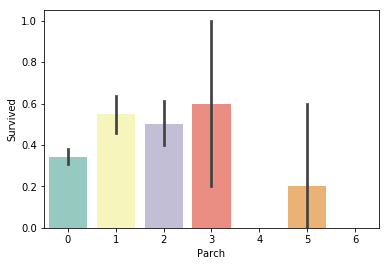

In [91]:
sns.barplot(x="Parch", y="Survived", data=train, palette='Set3')

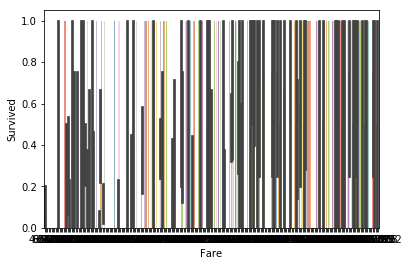

In [92]:
sns.barplot(x="Fare", y="Survived", data=train, palette='Set3')

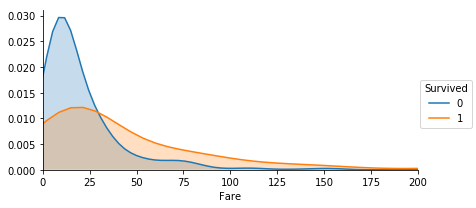

In [93]:
facet = sns.FacetGrid(train, hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, 200))
facet.add_legend()

In [94]:
train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

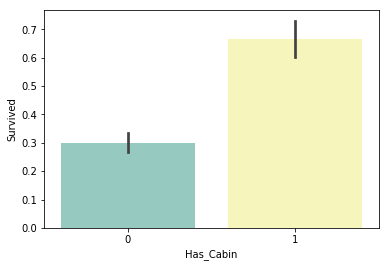

In [95]:
train.loc[train.Cabin.isnull(), 'Cabin'] = 'U0'
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if x == 'U0' else 1)
sns.barplot(x="Has_Cabin", y="Survived", data=train, palette='Set3')

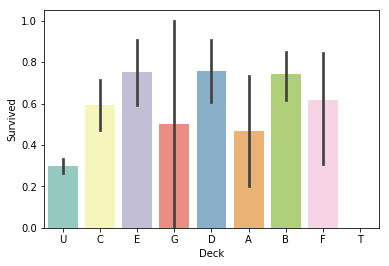

In [96]:
all_data['Cabin'] = all_data['Cabin'].fillna('Unknown')
all_data['Deck']=all_data['Cabin'].str.get(0)
sns.barplot(x="Deck", y="Survived", data=all_data, palette='Set3')

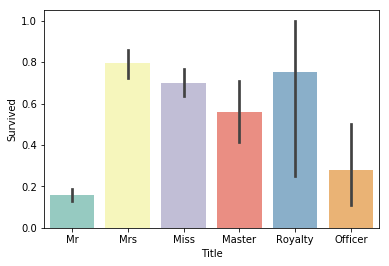

In [97]:
all_data['Title'] = all_data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))
all_data['Title'] = all_data['Title'].map(Title_Dict)
sns.barplot(x="Title", y="Survived", data=all_data, palette='Set3')

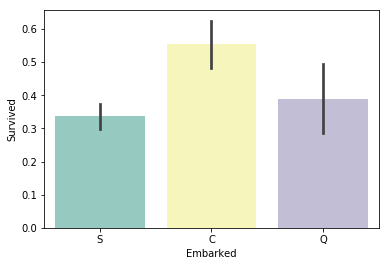

In [98]:
sns.barplot(x="Embarked", y="Survived", data=train, palette='Set3')

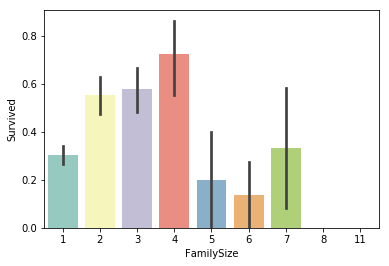

In [99]:
all_data['FamilySize']=all_data['SibSp']+all_data['Parch']+1
sns.barplot(x="FamilySize", y="Survived", data=all_data, palette='Set3')

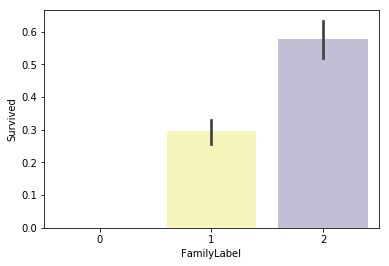

In [100]:
def Fam_label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7):
        return 0
all_data['FamilyLabel']=all_data['FamilySize'].apply(Fam_label)
sns.barplot(x="FamilyLabel", y="Survived", data=all_data, palette='Set3')

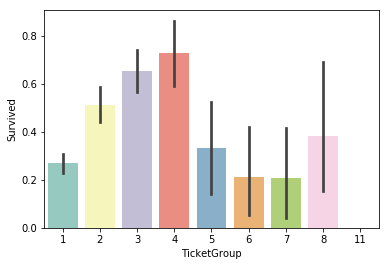

In [101]:
Ticket_Count = dict(all_data['Ticket'].value_counts())
all_data['TicketGroup'] = all_data['Ticket'].apply(lambda x:Ticket_Count[x])
sns.barplot(x='TicketGroup', y='Survived', data=all_data, palette='Set3')

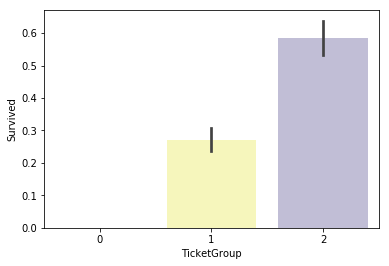

In [102]:
def Ticket_Label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1):
        return 1
    elif (s > 8):
        return 0

all_data['TicketGroup'] = all_data['TicketGroup'].apply(Ticket_Label)
sns.barplot(x='TicketGroup', y='Survived', data=all_data, palette='Set3')

In [103]:
###cv时对train data再做cv，子cv可以是2折，一半训练缺失值填充，一半填上缺失值并训练以预测顶级cv的test
###两次子cv的平均值，为顶cv的一个划分的结果。
from sklearn import cross_validation

train = all_data[all_data['Survived'].notnull()]
test  = all_data[all_data['Survived'].isnull()]
# 分割数据，按照 训练数据:cv数据 = 1:1的比例
train_split_1, train_split_2 = cross_validation.train_test_split(train, test_size=0.5, random_state=0)


def predict_age_use_cross_validationg(df1,df2,dfTest):
    age_df1 = df1[['Age', 'Pclass','Sex','Title']]
    age_df1 = pd.get_dummies(age_df1)
    age_df2 = df2[['Age', 'Pclass','Sex','Title']]
    age_df2 = pd.get_dummies(age_df2)
    
    known_age = age_df1[age_df1.Age.notnull()].as_matrix()
    unknow_age_df1 = age_df1[age_df1.Age.isnull()].as_matrix()
    unknown_age = age_df2[age_df2.Age.isnull()].as_matrix()
    
    print (unknown_age.shape)
    
    y = known_age[:, 0]
    X = known_age[:, 1:]
    
    rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
    rfr.fit(X, y)
    predictedAges = rfr.predict(unknown_age[:, 1::])
    df2.loc[ (df2.Age.isnull()), 'Age' ] = predictedAges 
    predictedAges = rfr.predict(unknow_age_df1[:,1::])
    df1.loc[(df1.Age.isnull()),'Age'] = predictedAges
    

    age_Test = dfTest[['Age', 'Pclass','Sex','Title']]
    age_Test = pd.get_dummies(age_Test)
    age_Tmp = df2[['Age', 'Pclass','Sex','Title']]
    age_Tmp = pd.get_dummies(age_Tmp)
    
    age_Tmp = pd.concat([age_Test[age_Test.Age.notnull()],age_Tmp])
    
    known_age1 = age_Tmp.as_matrix()
    unknown_age1 = age_Test[age_Test.Age.isnull()].as_matrix()
    y = known_age1[:,0]
    x = known_age1[:,1:]

    rfr.fit(x, y)
    predictedAges = rfr.predict(unknown_age1[:, 1:])
    dfTest.loc[ (dfTest.Age.isnull()), 'Age' ] = predictedAges 
    
    return dfTest
    
t1 = train_split_1.copy()
t2 = train_split_2.copy()
tmp1 = test.copy()
t5 = predict_age_use_cross_validationg(t1,t2,tmp1)
t1 = pd.concat([t1,t2])

t3 = train_split_1.copy()
t4 = train_split_2.copy()
tmp2 = test.copy()
t6 = predict_age_use_cross_validationg(t4,t3,tmp2)
t3 = pd.concat([t3,t4])

train['Age'] = (t1['Age'] + t3['Age'])/2


test['Age'] = (t5['Age'] + t6['Age']) / 2

print (train.describe())
print (test.describe())

all_data = pd.concat([train,test])

(92, 10)
(85, 10)
              Age        Fare       Parch  PassengerId      Pclass  \
count  891.000000  891.000000  891.000000   891.000000  891.000000   
mean    29.422814   32.204208    0.381594   446.000000    2.308642   
std     13.555050   49.693429    0.806057   257.353842    0.836071   
min      0.420000    0.000000    0.000000     1.000000    1.000000   
25%     21.000000    7.910400    0.000000   223.500000    2.000000   
50%     28.721672   14.454200    0.000000   446.000000    3.000000   
75%     36.750000   31.000000    0.000000   668.500000    3.000000   
max     80.000000  512.329200    6.000000   891.000000    3.000000   

            SibSp    Survived  FamilySize  FamilyLabel  TicketGroup  
count  891.000000  891.000000  891.000000   891.000000   891.000000  
mean     0.523008    0.383838    1.904602     1.313131     1.358025  
std      1.102743    0.486592    1.613459     0.494505     0.495814  
min      0.000000    0.000000    1.000000     0.000000     0.000000  
2

In [104]:
all_data[all_data['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Deck,Title,FamilySize,FamilyLabel,TicketGroup
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,B,Miss,1,1,2
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,B,Mrs,1,1,2


In [105]:
all_data['Embarked'] = all_data['Embarked'].fillna('C')

In [106]:
fare=all_data[(all_data['Embarked'] == "S") & (all_data['Pclass'] == 3)].Fare.median()
all_data['Fare']=all_data['Fare'].fillna(fare)

In [107]:
all_data['Surname']=all_data['Name'].apply(lambda x:x.split(',')[0].strip())
Surname_Count = dict(all_data['Surname'].value_counts())
all_data['FamilyGroup'] = all_data['Surname'].apply(lambda x:Surname_Count[x])
Female_Child_Group=all_data.loc[(all_data['FamilyGroup']>=2) & ((all_data['Age']<=12) | (all_data['Sex']=='female'))]
Male_Adult_Group=all_data.loc[(all_data['FamilyGroup']>=2) & (all_data['Age']>12) & (all_data['Sex']=='male')]

In [108]:
Female_Child=pd.DataFrame(Female_Child_Group.groupby('Surname')['Survived'].mean().value_counts())
Female_Child.columns=['GroupCount']
Female_Child

,GroupCount
1.000000,115
0.000000,31
0.750000,2
0.333333,1
0.142857,1


In [109]:
Male_Adult=pd.DataFrame(Male_Adult_Group.groupby('Surname')['Survived'].mean().value_counts())
Male_Adult.columns=['GroupCount']
Male_Adult

,GroupCount
0.000000,122
1.000000,20
0.500000,6
0.333333,2
0.250000,1


In [110]:
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()
Dead_List=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
print(Dead_List)
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()
Survived_List=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)
print(Survived_List)

{'Danbom', 'Ilmakangas', 'Robins', 'Caram', 'Strom', 'Panula', 'Johnston', 'Canavan', 'Lefebre', 'Van Impe', 'Ford', 'Goodwin', 'Boulos', 'Bourke', 'Oreskovic', 'Olsson', 'Zabour', 'Cacic', 'Jussila', 'Lobb', 'Attalah', 'Sage', 'Rice', 'Turpin', 'Skoog', 'Vander Planke', 'Palsson', 'Lahtinen', 'Rosblom', 'Barbara', 'Arnold-Franchi'}
{'Harder', 'Jonsson', 'Cardeza', 'Kimball', 'Nakid', 'Taylor', 'Bishop', 'Frauenthal', 'Frolicher-Stehli', 'Goldenberg', 'Beckwith', 'Dick', 'Jussila', 'Chambers', 'Duff Gordon', 'Greenfield', 'McCoy', 'Beane', 'Daly', 'Bradley'}


In [111]:
train=all_data.loc[all_data['Survived'].notnull()]
test=all_data.loc[all_data['Survived'].isnull()]
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Sex'] = 'male'
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Age'] = 60
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Title'] = 'Mr'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Sex'] = 'female'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Age'] = 5
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Title'] = 'Miss'
train.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Deck,Title,FamilySize,FamilyLabel,TicketGroup,Surname,FamilyGroup
0,22.0,Unknown,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,U,Mr,2,2,1,Braund,2
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,C,Mrs,2,2,2,Cumings,2
2,26.0,Unknown,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,U,Miss,1,1,1,Heikkinen,1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,C,Mrs,2,2,2,Futrelle,2
4,35.0,Unknown,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,U,Mr,1,1,1,Allen,2


In [112]:
all_data=pd.concat([train, test])
all_data=all_data[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','FamilyLabel','Deck','TicketGroup']]
all_data=pd.get_dummies(all_data)
train=all_data[all_data['Survived'].notnull()]
test=all_data[all_data['Survived'].isnull()].drop('Survived',axis=1)
X = train.as_matrix()[:,1:]
y = train.as_matrix()[:,0]

In [113]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 26 columns):
Survived         891 non-null float64
Pclass           891 non-null int64
Age              891 non-null float64
Fare             891 non-null float64
FamilyLabel      891 non-null int64
TicketGroup      891 non-null int64
Sex_female       891 non-null uint8
Sex_male         891 non-null uint8
Embarked_C       891 non-null uint8
Embarked_Q       891 non-null uint8
Embarked_S       891 non-null uint8
Title_Master     891 non-null uint8
Title_Miss       891 non-null uint8
Title_Mr         891 non-null uint8
Title_Mrs        891 non-null uint8
Title_Officer    891 non-null uint8
Title_Royalty    891 non-null uint8
Deck_A           891 non-null uint8
Deck_B           891 non-null uint8
Deck_C           891 non-null uint8
Deck_D           891 non-null uint8
Deck_E           891 non-null uint8
Deck_F           891 non-null uint8
Deck_G           891 non-null uint8
Deck_T           891 non-

In [114]:
pipe=Pipeline([('select',SelectKBest(k=20)), 
               ('classify', RandomForestClassifier(random_state = 10, max_features = 'sqrt'))])

param_test = {'classify__n_estimators':list(range(20,50,2)), 
              'classify__max_depth':list(range(3,60,3))}
gsearch = GridSearchCV(estimator = pipe, param_grid = param_test, scoring='roc_auc', cv=10)
gsearch.fit(X,y)
print(gsearch.best_params_, gsearch.best_score_)

{'classify__max_depth': 6, 'classify__n_estimators': 42} 0.8804824488491222


In [120]:
select = SelectKBest(k = 20)
clf = RandomForestClassifier(random_state = 10, warm_start = True, 
                                  n_estimators = 24,
                                  max_depth = 6, 
                                  max_features = 'sqrt')
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

Pipeline(memory=None,
     steps=[('selectkbest', SelectKBest(k=20, score_func=<function f_classif at 0x000001D5383E5048>)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decreas...estimators=24, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=True))])

In [121]:
predictions = pipeline.predict(test)
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv("submission.csv", index=False)